In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
from sklearn import tree
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util import importNotebook
from util.util import *
from util.dataProcess import *

Using TensorFlow backend.


importing Jupyter notebook from ../util/dataProcess.ipynb


## Load the datasets

In [2]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
yTrain = dummy(yTrain, numClass)
yTest = dummy(yTest, numClass)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


## Declare the parameters and layers

In [3]:
numEpochs = 40
sizeBatch = 32
dimInter = 64
dimEncode = 2
stdEps = 1.0 
ratRecon = 0.995
nameOptim = 'adam'

## Construct the encoder and decoder

In [6]:
layEncInt = Dense(dimInter, activation='relu')
layMean = Dense(dimEncode)
laySigma = Dense(dimEncode)
layDecInt = Dense(dimInter, activation='relu')
layDecode = Dense(dimInput, activation='sigmoid', name='layDecode')

layClass = Dense(10, activation='softmax', name='layClass')

inputs = Input(shape=(dimInput,))
interEncode = layEncInt(inputs)
zMean = layMean(interEncode)
zSigmaLog = laySigma(interEncode) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z, name='encoder')

inputZ = Input(shape=(dimEncode,))
interDecode = layDecInt(inputZ)
decode = layDecode(interDecode)
decoder = Model(inputZ, decode, name='decoder')

inputC = Input(shape=(dimEncode,))
output = layClass(inputC)
classifier = Model(inputC, output, name='classifier')

encoder.summary()
decoder.summary()
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           50240       input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            130         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            130         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

## Construct the autoencoder

In [7]:
vae = Model(inputs, [decoder(encoder(inputs)), classifier(encoder(inputs))])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 2)            50500       input_4[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          51152       encoder[1][0]                    
__________________________________________________________________________________________________
classifier (Model)              (None, 10)           30          encoder[2][0]                    
Total para

## Compile and train

In [8]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(tensorInput, tensorDecode)
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss


vae.compile(optimizer=nameOptim, loss={'decoder': lossVAE(zMean, zSigmaLog), 'classifier': 'binary_crossentropy'},
              loss_weights={'decoder': 0.5, 'classifier': 0.5})
tic = time()
history = vae.fit(xTrain, [xTrain, yTrain],
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, [xTest, yTest]))
timeTrain = time() - tic

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 17s 278us/step - loss: 0.2286 - decoder_loss: 0.2780 - classifier_loss: 0.1792 - val_loss: 0.1964 - val_decoder_loss: 0.2566 - val_classifier_loss: 0.1361
Epoch 2/40
60000/60000 [==============================] - 16s 262us/step - loss: 0.1869 - decoder_loss: 0.2579 - classifier_loss: 0.1159 - val_loss: 0.1780 - val_decoder_loss: 0.2538 - val_classifier_loss: 0.1022
Epoch 3/40
60000/60000 [==============================] - 16s 259us/step - loss: 0.1726 - decoder_loss: 0.2560 - classifier_loss: 0.0893 - val_loss: 0.1673 - val_decoder_loss: 0.2543 - val_classifier_loss: 0.0802
Epoch 4/40
60000/60000 [==============================] - 15s 248us/step - loss: 0.1628 - decoder_loss: 0.2544 - classifier_loss: 0.0712 - val_loss: 0.1599 - val_decoder_loss: 0.2516 - val_classifier_loss: 0.0681
Epoch 5/40
60000/60000 [==============================] - 15s 245us/step - loss: 0.1555 - decoder_

60000/60000 [==============================] - 15s 257us/step - loss: 0.1232 - decoder_loss: 0.2298 - classifier_loss: 0.0166 - val_loss: 0.1380 - val_decoder_loss: 0.2296 - val_classifier_loss: 0.0464
Epoch 40/40
60000/60000 [==============================] - 15s 255us/step - loss: 0.1230 - decoder_loss: 0.2297 - classifier_loss: 0.0163 - val_loss: 0.1379 - val_decoder_loss: 0.2301 - val_classifier_loss: 0.0458


## Show the historical training progress 

traing consumed: 609.5246798992157 seconds


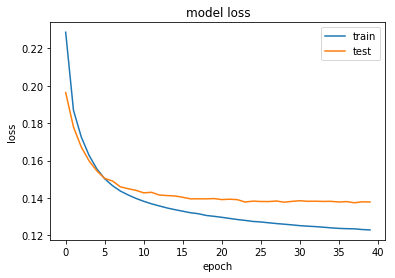

In [9]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [10]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

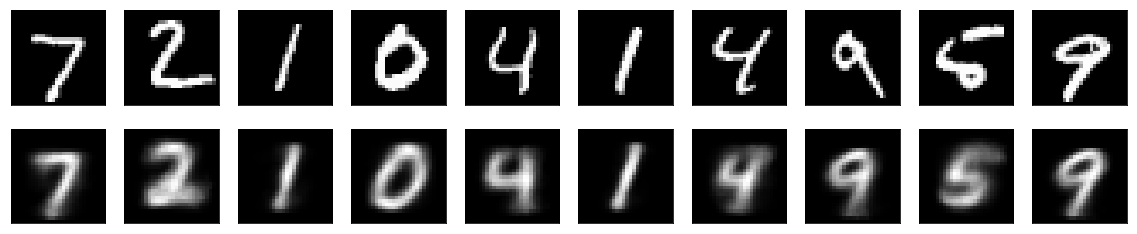

In [11]:
plotCompDecode(xTest, decodeTest)

## Plot the scatter of the encoding space

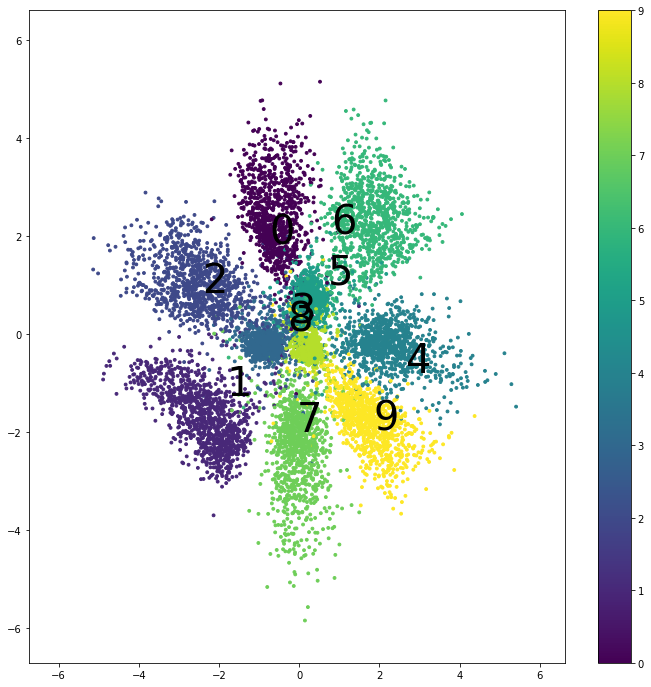

In [12]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, invDummy(yTest), xlim, ylim, numShow=10000, markersize=8)
scoreSilh = silhouette_score(encodeTest, invDummy(yTest))  

## Plot the decoding results from the encoding scatter 

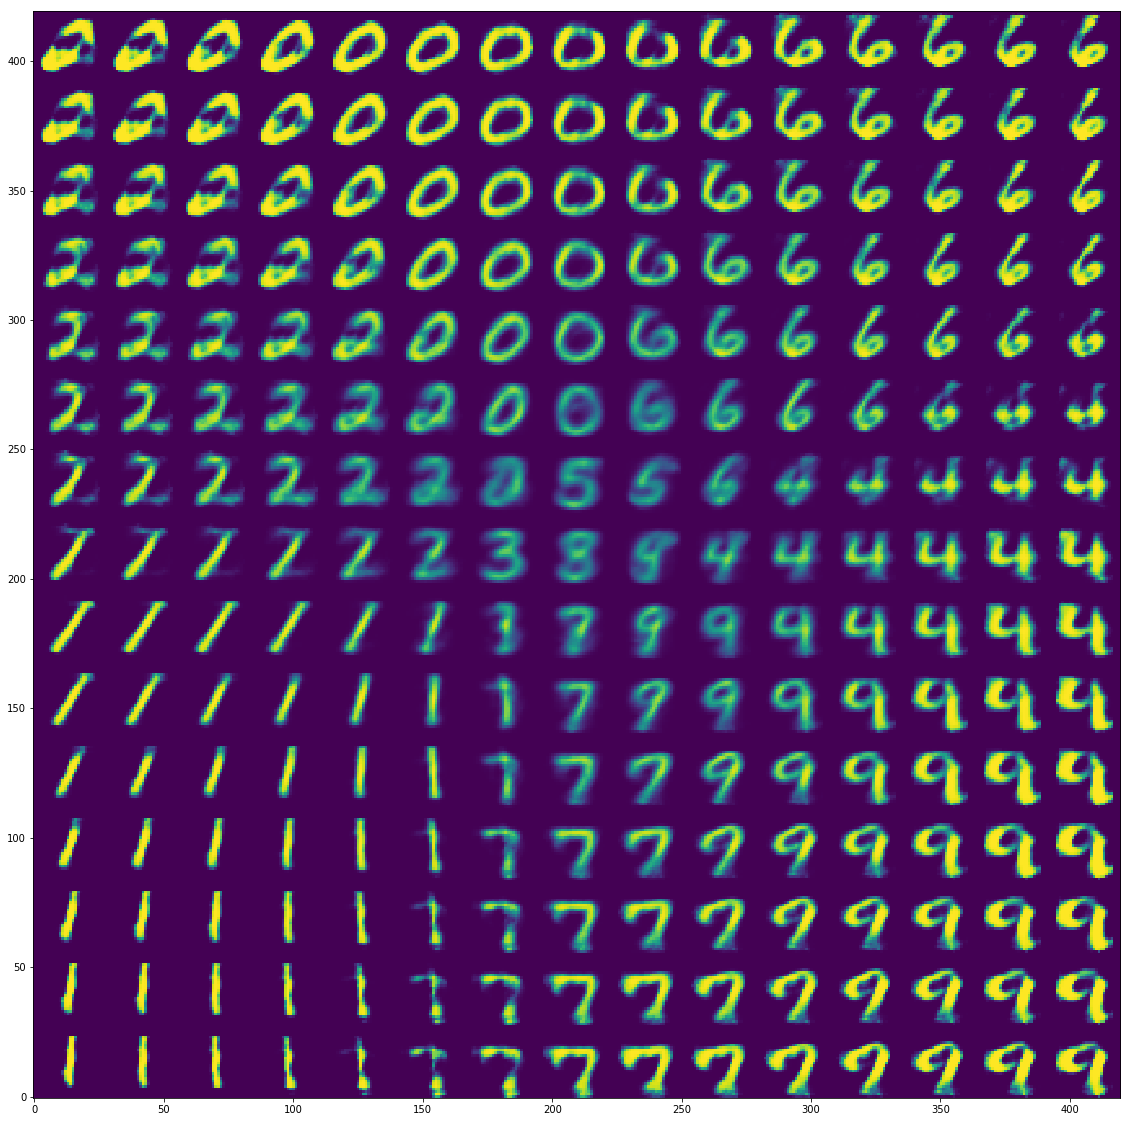

In [13]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit,sizeDigit), xlim, ylim)

In [13]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

511.8653795719147 0.1265249939521154 0.14238375709056855 0.39541313
